In [1]:
%matplotlib inline 
#widget
import sys 
import xarray as xr
import numpy as np
import os 
import warnings
import yaml
from random import randint
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *

In [2]:
#Only for multicore runs
def simple_partition_function(coords, mpi_size=1):
    """A very simple partition function
    that assigns particles to processors
    """
    return np.linspace(0, mpi_size, coords.shape[0], endpoint=False, dtype=np.int32)

In [3]:
config = ['/home/jvalenti/scratch/OParcels_runs/Parcels_outfall/outfall_runs.yaml']
restart = 0
paths = path(0)
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
ds = xr.open_dataset('/home/jvalenti/projects/rrg-allen/jvalenti/alpha020190101.nc', decode_times=False)

In [5]:
DS=ds.to_dataframe()

In [6]:
DS = DS.dropna()
DS = DS[DS.time>0]

In [7]:
DSb = DS[DS.status==2]
DSe = DS[DS.status==3]
DSex = DS[DS.status==5]
DS = DS[DS.status==1]

In [8]:
DSdeep = DS[DS.z>5]
DSshallow = DS[DS.z<800]

In [9]:
DSdep = DS[DS.z>5]
DSsall = DS[DS.z<800]
DSshal = DS[DS.z<5]
#DS = DS[DS.time == ds.time[0,1].values]

coords = xr.open_dataset('/home/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
mask = xr.open_dataset('/home/jvalenti/MOAD/grid2/mesh_mask202108_TDV.nc')


Text(0.5, 1.0, 'Deeper than 50 m')

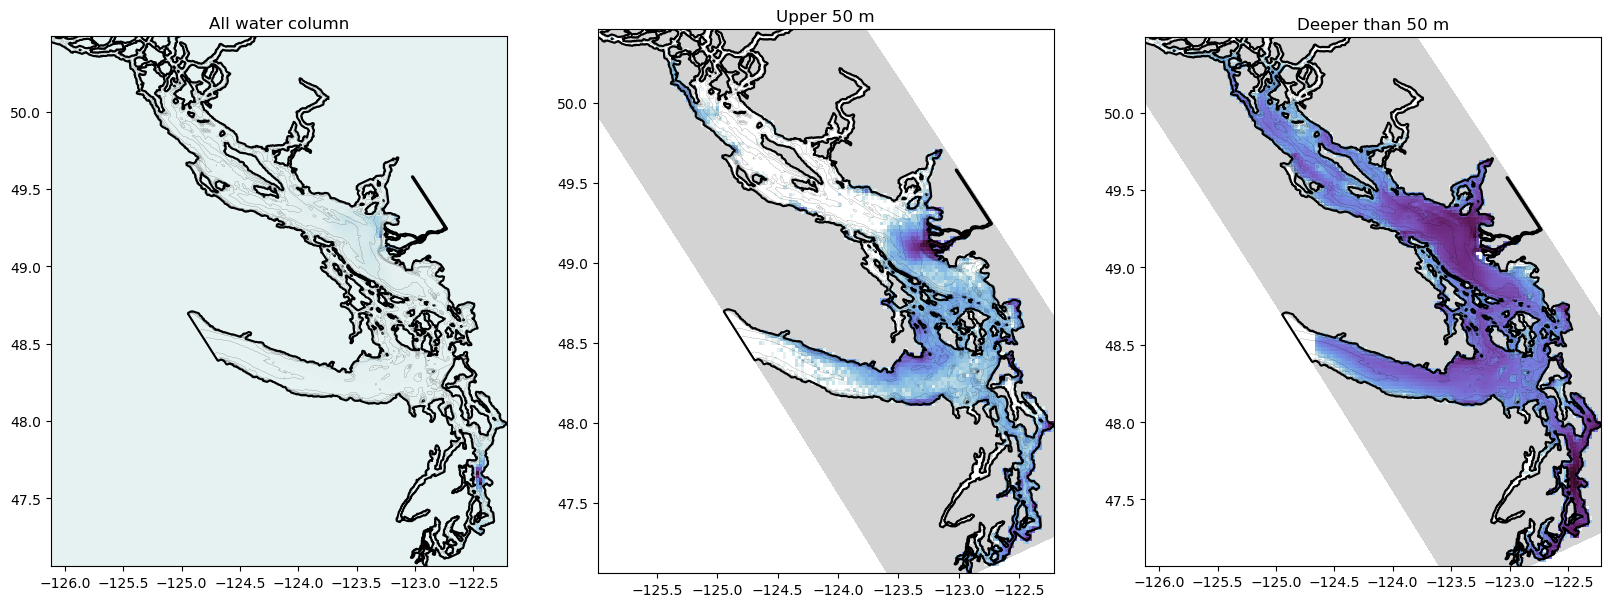

In [10]:
from matplotlib import pyplot as plt, animation, rc,colors
import cmocean
cm = cmocean.cm.dense

fig, ax = plt.subplots(1,3,figsize=(20, 16))

ax[0].contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax[0].contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
aa = ax[0].hist2d(DS.lon,DS.lat,150,cmap =cm)
ax[0].set_aspect(1/np.sin(np.deg2rad(49)))
ax[0].set_title('All water column')

ax[1].contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax[1].contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax[1].contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
aa = ax[1].hist2d(DSshal.lon,DSshal.lat,150,norm = colors.LogNorm(),cmap =cm)
ax[1].set_aspect(1/np.sin(np.deg2rad(49)))
ax[1].set_title('Upper 50 m')
#cb2=fig.colorbar(aa,ax=ax,pad=0.01)

ax[2].contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax[2].contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax[2].contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
aa = ax[2].hist2d(DSdep.lon,DSdep.lat,150,norm = colors.LogNorm(),cmap =cm)
ax[2].set_aspect(1/np.sin(np.deg2rad(49)))
ax[2].set_title('Deeper than 50 m')


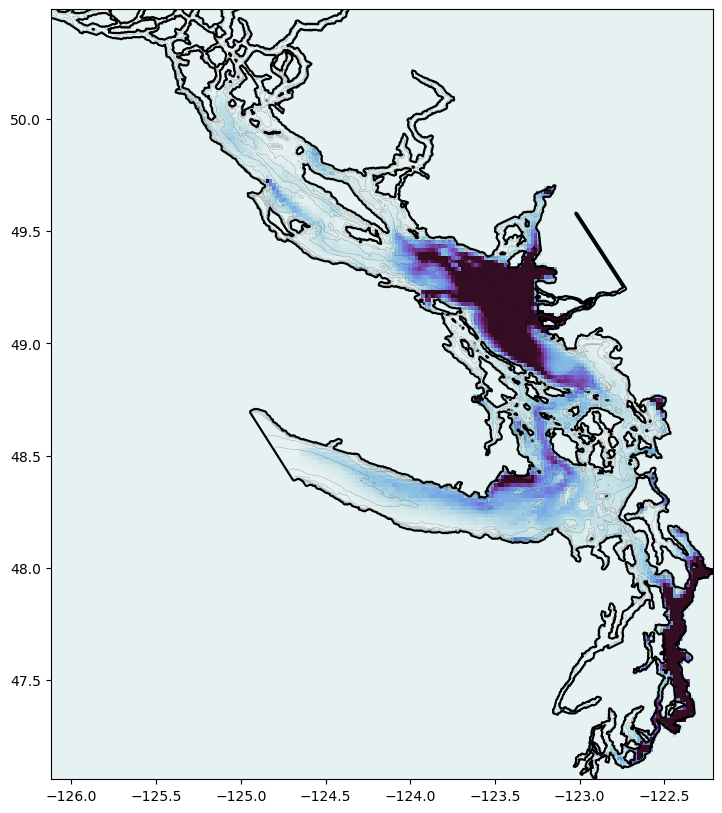

In [21]:
from matplotlib import pyplot as plt, animation, rc,colors
import cmocean
cm = cmocean.cm.dense

fig, ax = plt.subplots(1,1,figsize=(10, 10))

ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
aa = ax.hist2d(DS.lon,DS.lat,200,cmap =cm,vmin=1e-5,vmax=2000)
ax.set_aspect(1/np.sin(np.deg2rad(49)))

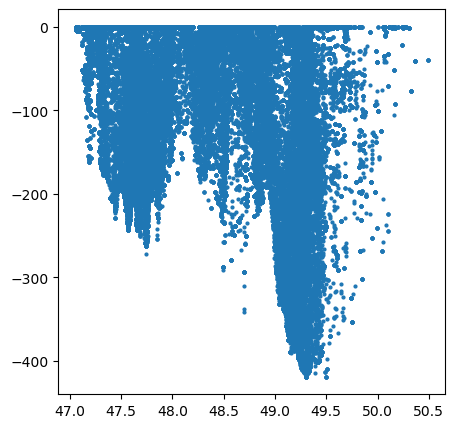

In [22]:
from matplotlib import pyplot as plt, animation, rc,colors
import cmocean
cm = cmocean.cm.dense

fig, ax = plt.subplots(1,1,figsize=(5, 5))

#ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
#ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
#ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
aa = plt.scatter(ds.lat[:,-10:],-ds.z[:,-10:],s =4)
#ax.set_aspect(1/np.sin(np.deg2rad(49)))

In [23]:
count = []
countb = []
counte = []
countex = []
for i in range(62):
    times= DS.time.iloc[0]+i*12*3600
    count.append(len(DS[DS.time == times]))
    counte.append(len(DSe[DSe.time == times]))
    countb.append(len(DSb[DSb.time == times]))
    countex.append(len(DSex[DSex.time == times]))

In [24]:
def exponential_decay(a, b, N):
    # a, b: exponential decay parameter
    # N: number of samples 
    return a * (1-b) ** np.arange(N)
a = exponential_decay(count[0], 1/10, 60)

251303

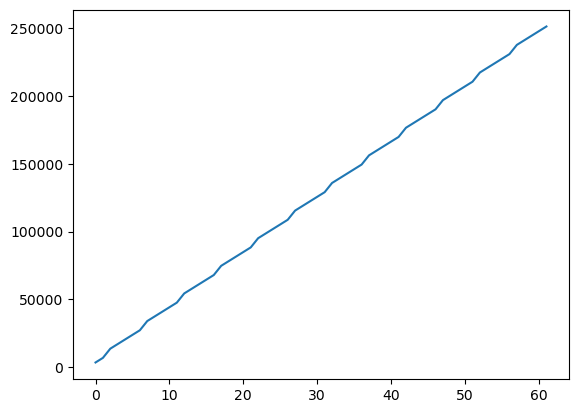

In [25]:
plt.plot([count[i]+countb[i]+counte[i]+countex[i] for i in range(len(count))])
[count[i]+countb[i]+counte[i]+countex[i] for i in range(len(count))][-1]

Text(0.5, 1.0, '$\\alpha$ = 0.1%')

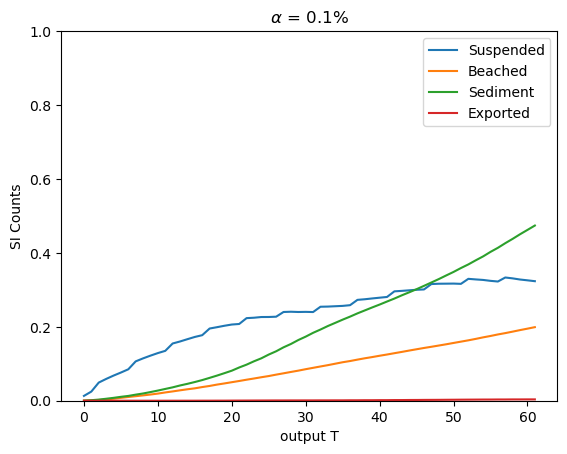

In [26]:
plt.plot(np.divide(count[:100],251303),label = 'Suspended')
plt.plot(np.divide(countb[:100],251303),label = 'Beached')
plt.plot(np.divide(counte[:100],251303),label = 'Sediment')
plt.plot(np.divide(countex[:100],251303),label = 'Exported')
plt.legend()
plt.ylabel('SI Counts')
plt.xlabel('output T')
plt.ylim([0,1])
plt.title(r'$\alpha$ = 0.1%')

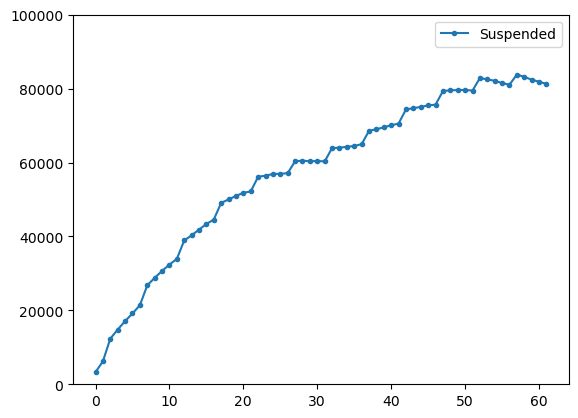

In [27]:
plt.plot(count[:100],'.-',label = 'Suspended')
#plt.plot(countb[:100],label = 'Beached')
#plt.plot(counte[:100],label = 'Sediment')
plt.ylim([0,1e5])
plt.legend()

In [28]:
path_NEMO = make_prefix(datetime(2019, 1, 1),paths['NEMO'])
jjii = xr.open_dataset('~/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i